In [1]:

import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
file_path = '/kaggle/input/energy-molecule/roboBohr.csv'
data = pd.read_csv(file_path)
print(data.head())

/kaggle/input/energy-molecule/roboBohr.csv
   Unnamed: 0          0          1          2          3          4  \
0           0  73.516695  17.817765  12.469551  12.458130  12.454607   
1           1  73.516695  20.649126  18.527789  17.891535  17.887995   
2           2  73.516695  17.830377  12.512263  12.404775  12.394493   
3           3  73.516695  17.875810  17.871259  17.862402  17.850920   
4           4  73.516695  17.883818  17.868256  17.864221  17.818540   

           5          6          7          8  ...  1267  1268  1269  1270  \
0  12.447345  12.433065  12.426926  12.387474  ...   0.0   0.0   0.5   0.0   
1  17.871731  17.852586  17.729842  15.864270  ...   0.0   0.0   0.0   0.0   
2  12.391564  12.324461  12.238106  10.423249  ...   0.0   0.0   0.0   0.0   
3  17.850440  12.558105  12.557645  12.517583  ...   0.0   0.0   0.0   0.0   
4  12.508657  12.490519  12.450098  10.597068  ...   0.0   0.0   0.0   0.0   

   1271  1272  1273  1274  pubchem_id        Eat  
0   

In [ ]:
#The goal is to predict the Eat - atomization energy by the molecular features.

In [2]:
missing_value_by_column = (data.isnull().sum())
print(missing_value_by_column[missing_value_by_column > 0])

Series([], dtype: int64)


In [3]:
#Find categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
[]


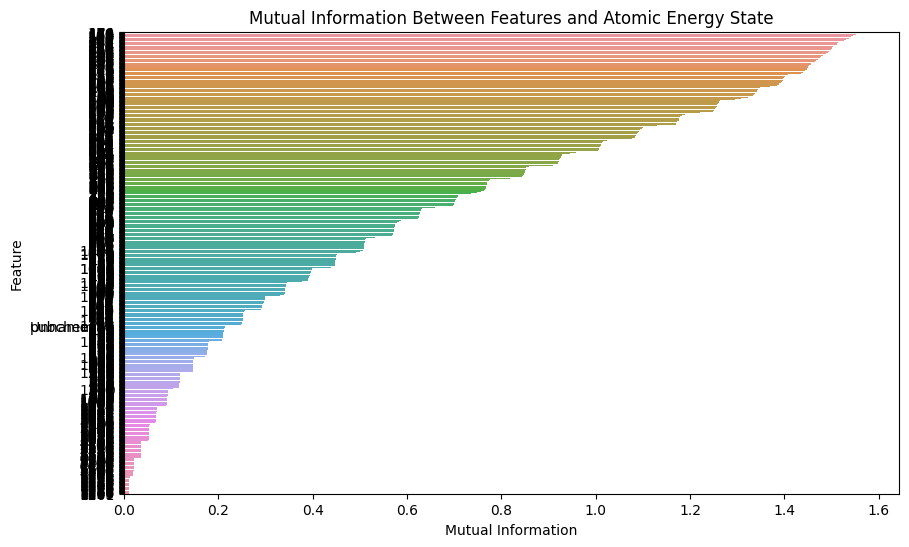

     Feature  Mutual Information
157      156            1.564897
175      174            1.559543
156      155            1.558724
174      173            1.557622
171      170            1.553102
...      ...                 ...
1259    1258            0.010944
1260    1259            0.010934
1246    1245            0.010839
1258    1257            0.010814
1262    1261            0.010743

[1277 rows x 2 columns]


In [5]:
backup_data = data.copy()
#Mutual information
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns

#Seperating the target variable
X = data.drop(columns = ['Eat'])
y = data['Eat']

mi = mutual_info_regression(X , y)
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})

#Sort by mutual information values to get the most informative features
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

#Visualize the mutual information using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df)
plt.title('Mutual Information Between Features and Atomic Energy State')
plt.show()

# Print the mutual information DataFrame
print(mi_df)

In [6]:
#Extract features with mutual informatioon greater than 1
selected_features = mi_df[mi_df['Mutual Information']>1]['Feature']

#Filter the original data to retain only selected features
X_new = data[selected_features]
print("Selected features dataframe:")
print(X_new)

Selected features dataframe:
            156       174       155       173       170       172       154  \
0      2.085187  1.471657  2.209435  1.478184  1.480597  1.479409  2.251036   
1      0.860515  0.706695  0.865017  0.714703  0.751030  0.726426  0.869726   
2      0.646605  0.231124  0.668236  0.231361  0.297568  0.231699  0.670116   
3      1.256224  1.141741  1.260873  1.145642  1.154396  1.146821  1.263537   
4      0.230471  0.172604  0.237370  0.172971  0.175866  0.173138  0.293369   
...         ...       ...       ...       ...       ...       ...       ...   
16237  0.443676  0.297924  0.444716  0.297959  0.298822  0.297975  0.444903   
16238  1.152845  1.080897  1.162917  1.083383  1.095677  1.084643  1.163238   
16239  2.895578  2.800724  2.895751  2.879061  2.886462  2.881383  2.896054   
16240  1.012468  0.938372  1.012503  0.940735  0.944835  0.940911  1.046435   
16241  1.003265  0.933320  1.012393  0.935835  0.944419  0.941812  1.057542   

            153       

In [9]:

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_new, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define the MLP model
mlp_model = MLPRegressor(
    hidden_layer_sizes=(256,128,64, 32,16,8), # Two hidden layers
    activation='relu',          # Activation function
    solver='adam',              # Optimizer
    alpha=0.001,                # L2 regularization (weight decay)
    learning_rate='adaptive',   # Adjust learning rate during training
    max_iter=500,               # Maximum epochs
    random_state=42
)

# Train the model with early stopping
best_loss = np.inf
patience = 10
no_improvement = 0

for epoch in range(500):
    mlp_model.partial_fit(X_train, y_train)  # Perform one epoch of training
    
    # Evaluate on the validation set
    y_val_pred = mlp_model.predict(X_val)
    val_loss = mean_squared_error(y_val, y_val_pred)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1
    
    # Stop early if no improvement
    if no_improvement >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Evaluate on the test set
y_test_pred = mlp_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test Mean Squared Error: {test_mse:.4f}")
print(f"Test R-squared Score: {test_r2:.4f}")


Early stopping at epoch 42
Test Mean Squared Error: 0.2355
Test R-squared Score: 0.9825


Early stopping at epoch 17
Animation saved as model_training_animation.mp4


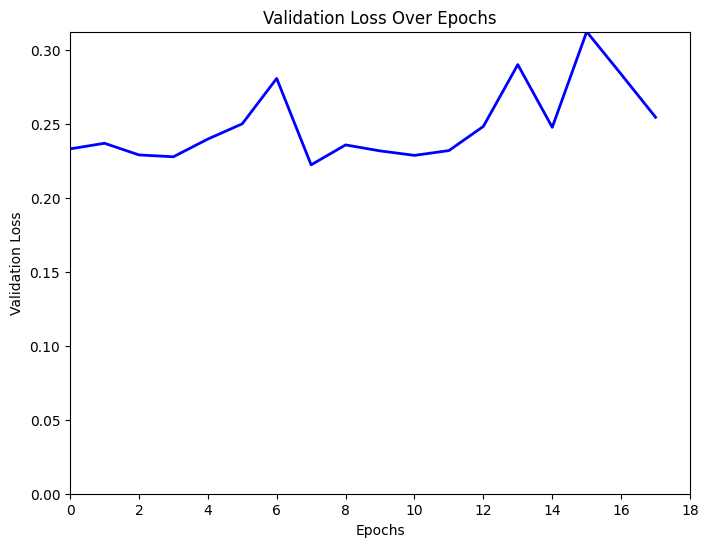

In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

# Track validation losses for animation
validation_losses = []

# Train the model with early stopping and track losses
best_loss = np.inf
patience = 10
no_improvement = 0

for epoch in range(500):
    mlp_model.partial_fit(X_train, y_train)  # Perform one epoch of training
    
    # Evaluate on the validation set
    y_val_pred = mlp_model.predict(X_val)
    val_loss = mean_squared_error(y_val, y_val_pred)
    validation_losses.append(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1
    
    # Stop early if no improvement
    if no_improvement >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Create animation for validation loss
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, len(validation_losses))
ax.set_ylim(0, max(validation_losses))
ax.set_xlabel('Epochs')
ax.set_ylabel('Validation Loss')
ax.set_title('Validation Loss Over Epochs')

line, = ax.plot([], [], color='blue', lw=2)

# Function to initialize the animation
def init():
    line.set_data([], [])
    return line,

# Function to update the animation
def update(frame):
    line.set_data(range(frame + 1), validation_losses[:frame + 1])
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(validation_losses), init_func=init, blit=True)

# Save animation as MP4 or GIF
ani.save("MLP.gif", writer="imagemagick", fps=2)


print("Animation saved as model_training_animation.mp4")
